In [1]:
!nvidia-smi

Thu Sep 12 19:30:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [3]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q
!python setup.py build_ext --inplace

fatal: destination path 'segment-anything-2' already exists and is not an empty directory.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for SAM-2 (pyproject.toml) ... done
running build_ext
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:495: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:414: UserWarning: The detected CUDA version (12.2) has a minor version mismatch with the version that was used to compile PyTorch (12.1). Most likely this shouldn't be a problem.
  warnings.warn(CUDA_MISMATCH_WARN.format(cuda_str_version, torch.version.c

In [4]:
!pip install -q supervision[assets] jupyter_bbox_widget

In [5]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

In [6]:
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from pathlib import Path
from supervision.assets import download_assets, VideoAssets
from sam2.build_sam import build_sam2_video_predictor

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

In [7]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2_video_predictor(CONFIG, CHECKPOINT)

In [22]:
SCALE_FACTOR = 0.5

SOURCE_VIDEO =  f"{HOME}/sheep_on_farm_wide.mp4"
SOURCE_FRAMES = Path(HOME) / Path(SOURCE_VIDEO).stem
SOURCE_FRAMES.mkdir(parents=True, exist_ok=True)

cap = cv2.VideoCapture(SOURCE_VIDEO)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Total frames: {total_frames}")
cap.release()

Total frames: 443


In [23]:
frames_generator = sv.get_video_frames_generator(SOURCE_VIDEO, start=0, end=total_frames)
images_sink = sv.ImageSink(
    target_dir_path=SOURCE_FRAMES.as_posix(),
    overwrite=True,
    image_name_pattern="{:05d}.jpeg"
)

with images_sink:
    for frame in frames_generator:
        frame = sv.scale_image(frame, SCALE_FACTOR)
        images_sink.save_image(frame)

TARGET_VIDEO = Path(HOME) / f"{Path(SOURCE_VIDEO).stem}-result.mp4"
SOURCE_FRAME_PATHS = sorted(sv.list_files_with_extensions(SOURCE_FRAMES.as_posix(), extensions=["jpeg"]))
SOURCE_IMAGE = SOURCE_FRAMES / "00000.jpeg"

In [24]:
inference_state = sam2_model.init_state(video_path=SOURCE_FRAMES.as_posix())

frame loading (JPEG): 100%|██████████| 443/443 [00:24<00:00, 18.18it/s]


In [25]:
sam2_model.reset_state(inference_state)

In [26]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [27]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(SOURCE_IMAGE)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [14]:
# widget.bboxes

In [28]:
default_box = widget.bboxes

boxes = widget.bboxes if widget.bboxes else default_box

points = np.array([
    [
        box['x'],
        box['y']
    ] for box in boxes
], dtype=np.float32)
labels = np.ones(len(points))

In [29]:
FRAME_IDX = 0
OBJECT_ID = 1

_, object_ids, mask_logits = sam2_model.add_new_points(
    inference_state=inference_state,
    frame_idx=FRAME_IDX,
    obj_id=OBJECT_ID,
    points=points,
    labels=labels,
)
masks = (mask_logits[0] > 0.0).cpu().numpy()

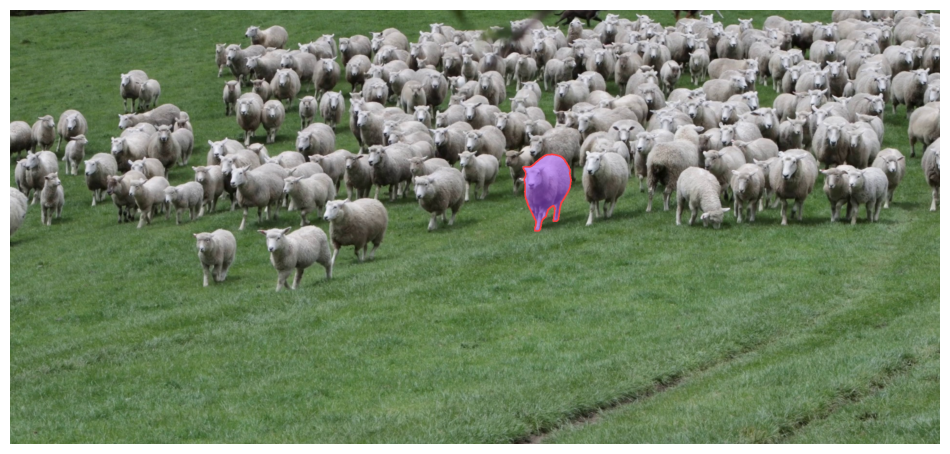

In [30]:
img_bgr = cv2.imread(SOURCE_IMAGE)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks,
    class_id=np.array(object_ids)
)

segemnted_image = mask_annotator.annotate(scene=img_bgr.copy(), detections=detections)

polygon_annotator = sv.PolygonAnnotator()
annotated_frame = polygon_annotator.annotate(
scene=segemnted_image.copy(),
detections=detections
)
sv.plot_image(annotated_frame)

In [31]:
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
video_info.width = int(video_info.width * SCALE_FACTOR)
video_info.height = int(video_info.height * SCALE_FACTOR)

frame_paths = sorted(sv.list_files_with_extensions(SOURCE_FRAMES.as_posix(), extensions=["jpeg"]))

with sv.VideoSink(TARGET_VIDEO.as_posix(), video_info=video_info) as sink:
    for frame_idx, object_ids, mask_logits in sam2_model.propagate_in_video(inference_state):
        frame_path = frame_paths[frame_idx]
        frame = cv2.imread(frame_path)

        # Convert mask logits to boolean masks
        masks = (mask_logits[0] > 0.0).cpu().numpy()

        # Ensure masks is 3D
        if masks.ndim == 4:  # Possibly extra dimension, squeeze to (N, W, H)
            masks = np.squeeze(masks)
        elif masks.ndim == 2:  # If it becomes 2D, add back the batch dimension
            masks = masks[np.newaxis, ...]

        # Create a binary mask with white for the object and black for the background
        binary_mask = np.where(masks[0] > 0.0, 255, 0).astype(np.uint8)

        # Create an empty black image with the same size as the original frame
        black_image = np.zeros_like(frame)

        # Apply the binary mask to the black image (white mask, black background)
        masked_image = cv2.bitwise_and(black_image, black_image, mask=binary_mask)

        # Set the white pixels in the mask area
        masked_image[binary_mask == 255] = [255, 255, 255]  # White for the mask area

        # Save the processed frame with the white mask and black background
        sink.write_frame(masked_image)

propagate in video: 100%|██████████| 443/443 [08:45<00:00,  1.19s/it]
